In [3]:
import numpy as np
import matplotlib.pyplot as plt
from readers.holo_reader import HoloReader
from writers.video_writer import write_video
from compute.space_transforms.fresnel import fresnel_transform
from compute.time_transforms.pca import pca
from settings.settings import Settings
from settings.space_transform_settings import SpaceTransformSettings
from settings.time_transform_settings import TimeTransformSettings
from enums import TransformType

Frame dimensions: 512 x 320


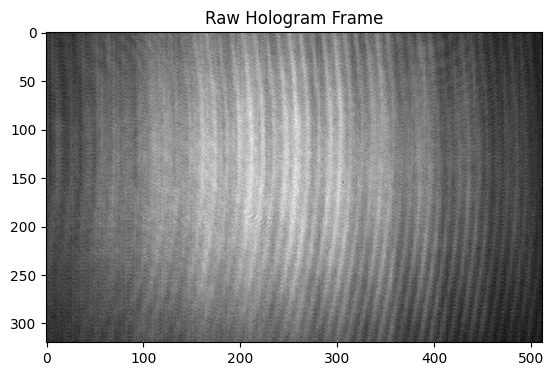

In [8]:
filename = "E:\\250512\\250512_GUJ_L.holo"
reader = HoloReader(filename, load_all_file=False)
settings = Settings()

settings.batch_size = 256
settings.sliding_average_window_size = 32
settings.use_double_precision = False
settings.batch_stride = 256

settings.space_transform = SpaceTransformSettings(
    z=reader.footer["compute_settings"]["image_rendering"]["propagation_distance"],
    wavelength=reader.footer["compute_settings"]["image_rendering"]["lambda"],
    x_step=reader.footer["info"]["pixel_pitch"]["x"] * 1e-6,
    y_step=reader.footer["info"]["pixel_pitch"]["y"] * 1e-6,
    use_double_precision=False,
    shift_after=True,
    transform_type=TransformType.FRESNEL
)

settings.time_transform.transform_type = TransformType.PCA
print("Frame dimensions:", reader.frame_width, "x", reader.frame_height)

batch = reader.read_frame_batch(batch_size=32, frame_position=1)

plt.imshow(np.abs(batch[0]), cmap='gray')
plt.title("Raw Hologram Frame")
plt.show()

Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False


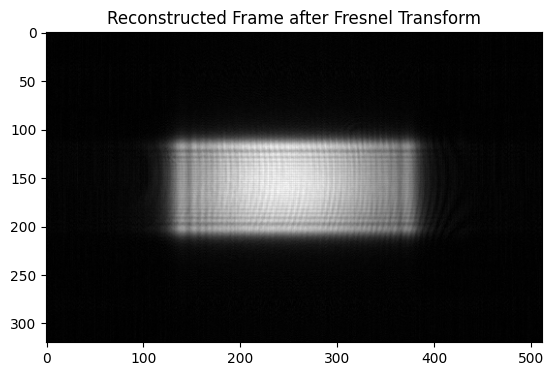

In [9]:
batch = fresnel_transform(
        frames=batch,
        settings=settings
    )
    

plt.imshow(np.abs(batch[0]), cmap='gray')
plt.title("Reconstructed Frame after Fresnel Transform")
plt.show()

Computing PCA Transform H shape: (32, 320, 512)


Text(0.5, 1.0, 'First Principal Component Frame')

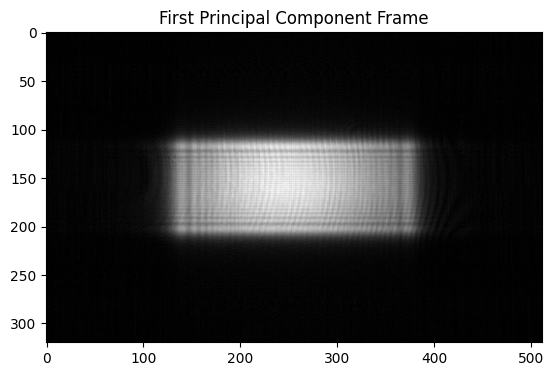

In [10]:
from compute.time_transforms.pca import pca
batch = pca(batch, settings=settings)

plt.imshow(np.abs(batch[0]), cmap='gray')
plt.title("First Principal Component Frame")

Text(0.5, 1.0, 'Tenth Principal Component Frame')

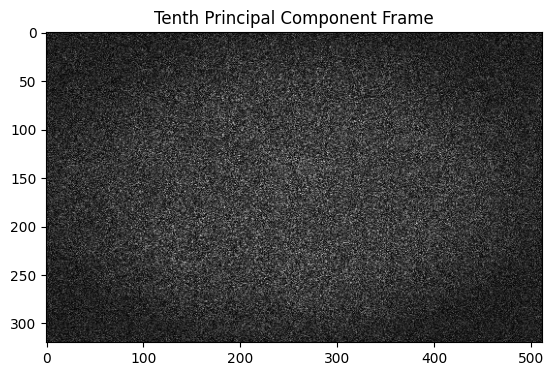

In [11]:

plt.imshow(np.abs(batch[10]), cmap='gray')
plt.title("Tenth Principal Component Frame")

Average frame shape: (320, 512)


Text(0.5, 1.0, 'Average Frame across Principal Components')

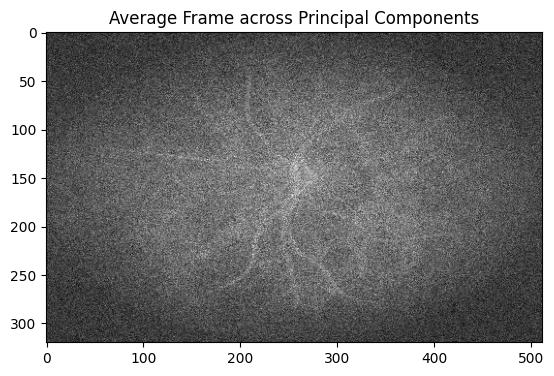

In [12]:
from postprocessing.sliding_average import batch_average
avg_frame = batch_average(batch, start=16, end=32)
print("Average frame shape:", avg_frame.shape)
plt.imshow(avg_frame, cmap='gray')
plt.title("Average Frame across Principal Components")      

In [13]:
from postprocessing.normalize import normalize_frames
from compute.time_transforms.stft import stft

total = []
for i in range(32):
    batch  = reader.read_frame_batch(batch_size=32, frame_position=i*32+1)
    space_tranformed = fresnel_transform(
        frames=batch,
        settings=settings
    )
    time_transformed = stft(space_tranformed, settings=settings)
    normalized = normalize_frames(time_transformed, settings=settings)
    avg_frame = batch_average(normalized, start=16, end=32)
    total.append(avg_frame)

total = np.array(total)



Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
Computing STFT Transform H shape: (32, 320, 512)
Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
Computing STFT Transform H shape: (32, 320, 512)
Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
Computing STFT Transform H shape: (32, 320, 512)
Computing Fresnel kernel with Nx=512, Ny=320, z_propagation_distance=0.4740000069141388, wavelength=8.519999710188131e-07, x_step=1.9999999999999998e-05, y_step=1.9999999999999998e-05, use_double_precision=False
Compu

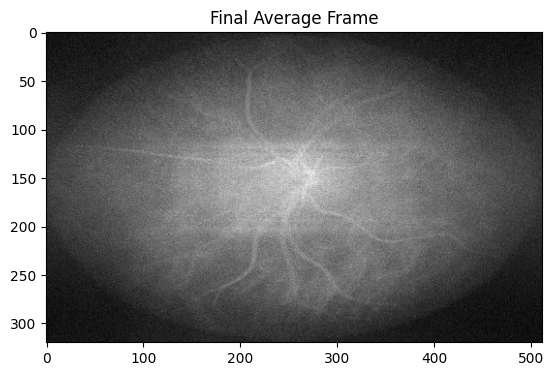

In [15]:
avg = batch_average(np.array(total))

plt.imshow(avg, cmap='gray')
plt.title("Final Average Frame")
plt.show()

In [12]:
from pathlib import Path
from writers.video_writer import write_video

# Get the current working directory of the notebook
notebook_dir = Path().resolve()
save_path = notebook_dir / "../output/output_video.avi"   # include extension!
print("Saving video to:", save_path)

write_video(total, str(save_path), fps=30, format='avi')


Saving video to: C:\STAGE\Python\PyDoppler\src\..\output\output_video.avi
Video saved: output/C:\STAGE\Python\PyDoppler\src\..\output\output_video.avi (avi, 32 frames, 30 FPS)
